In [43]:
import pandas as pd
import numpy as np
import itertools
import pickle
import matplotlib
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle

# matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

In [44]:
df = pd.read_csv('df_features.csv')
print(df.shape)
df.head()

(1000, 54)


,file_name,signal_mean,signal_std,zcr_mean,zcr_std,mfccs_1_mean,mfccs_2_mean,mfccs_3_mean,mfccs_4_mean,mfccs_5_mean,...,chroma_censs_3_mean,chroma_censs_4_mean,chroma_censs_5_mean,chroma_censs_6_mean,chroma_censs_7_mean,chroma_censs_8_mean,chroma_censs_9_mean,chroma_censs_10_mean,chroma_censs_11_mean,chroma_censs_12_mean
0,genres/hiphop/hiphop.00033.au,0.172,0.221,0.153,0.088,-31.729,59.700,-2.744,33.421,13.094,...,0.299,0.347,0.280,0.239,0.257,0.212,0.209,0.228,0.310,0.280
1,genres/hiphop/hiphop.00051.au,0.197,0.259,0.099,0.087,-78.679,73.101,21.824,49.199,3.109,...,0.279,0.354,0.386,0.264,0.170,0.202,0.260,0.339,0.323,0.253
2,genres/hiphop/hiphop.00015.au,0.107,0.154,0.116,0.050,-81.873,94.714,-16.213,40.539,-12.243,...,0.244,0.286,0.255,0.205,0.338,0.378,0.316,0.238,0.257,0.305
3,genres/hiphop/hiphop.00042.au,0.204,0.265,0.102,0.075,-74.732,48.884,3.822,36.294,12.973,...,0.593,0.436,0.174,0.131,0.165,0.228,0.186,0.129,0.119,0.108
4,genres/hiphop/hiphop.00006.au,0.213,0.299,0.128,0.097,-59.579,63.909,3.458,45.271,-1.146,...,0.264,0.319,0.322,0.301,0.336,0.348,0.313,0.266,0.222,0.179


In [45]:
label_dict = {
    'blues':0,
    'classical':1,
    'country':2,
    'disco':3,
    'hiphop':4,
    'jazz':5,
    'metal':6,
    'pop':7,
    'reggae':8,
    'rock':9,
}

# Normalization of the features
scalar = MinMaxScaler()
df[df.columns[1:]] = scalar.fit_transform(df[df.columns[1:]])
df['label'] = df['file_name'].apply(lambda x: label_dict[x.split('/')[2][:-9]])
df.head()

,file_name,signal_mean,signal_std,zcr_mean,zcr_std,mfccs_1_mean,mfccs_2_mean,mfccs_3_mean,mfccs_4_mean,mfccs_5_mean,...,chroma_censs_4_mean,chroma_censs_5_mean,chroma_censs_6_mean,chroma_censs_7_mean,chroma_censs_8_mean,chroma_censs_9_mean,chroma_censs_10_mean,chroma_censs_11_mean,chroma_censs_12_mean,label
0,genres/hiphop/hiphop.00033.au,0.523364,0.533835,0.519841,0.500000,0.875845,0.314362,0.594502,0.524480,0.739134,...,0.688488,0.446154,0.379610,0.456067,0.376906,0.284024,0.375536,0.517928,0.444685,4
1,genres/hiphop/hiphop.00051.au,0.601246,0.629073,0.305556,0.493827,0.796825,0.383241,0.762141,0.683164,0.597162,...,0.704289,0.679121,0.433839,0.274059,0.355120,0.384615,0.613734,0.543825,0.386117,4
2,genres/hiphop/hiphop.00015.au,0.320872,0.365915,0.373016,0.265432,0.791450,0.494328,0.502596,0.596068,0.378880,...,0.550790,0.391209,0.305857,0.625523,0.738562,0.495069,0.396996,0.412351,0.498915,4
3,genres/hiphop/hiphop.00042.au,0.623053,0.644110,0.317460,0.419753,0.803468,0.258770,0.639305,0.553374,0.737413,...,0.889391,0.213187,0.145336,0.263598,0.411765,0.238659,0.163090,0.137450,0.071584,4
4,genres/hiphop/hiphop.00006.au,0.651090,0.729323,0.420635,0.555556,0.828972,0.335996,0.636821,0.643659,0.536662,...,0.625282,0.538462,0.514100,0.621339,0.673203,0.489152,0.457082,0.342629,0.225597,4


In [46]:
len(df)

1000

In [47]:
with open('pred_probas/testset_filenames.txt', 'r') as f:
    test_files = f.readlines()
test_files = [t.strip() for t in test_files]
test_files[:3]

['reggae_00025.au', 'blues_00015.au', 'metal_00059.au']

In [48]:
# Train-test split of files # Same split as used for VGG model
# with open('pred_probas/testset_filenames.txt', 'r') as f:
#     test_files = f.readlines()
# test_files = [t.strip() for t in test_files]

# for ind, t in enumerate(test_files):
#     test_files[ind] = 'genres/' + t.split('_')[0] + '/' + t.split('_')[0] + '.' + t.split('_')[1]

# indices = []
# for t in test_files:
#     indices.append(df[df.file_name== t].index[0])
    
# df_test = df.iloc[indices,:]
# df.drop(labels=indices, inplace=True)

# x_train = df[df.columns[1:-1]]
# x_test = df_test[df.columns[1:-1]]
# y_train = df['label']
# y_test = df_test['label']

In [59]:
ran = pd.DataFrame(np.random.randn(1000, 2))
msk = np.random.rand(len(ran)) < 0.8
train = df[msk]
test = df[~msk]

In [60]:
x_train = train[df.columns[1:-1]]
x_test = test[df.columns[1:-1]]
y_train = train['label']
y_test = test['label']

In [61]:
len(x_train)

795

In [62]:
len(x_test)

205

In [63]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt

In [64]:
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(classifier, y_test, pred_probs, cm = True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(label_dict))
    print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))
    if cm:
        pl = plot_confusion_matrix(confusion_matrix(y_test, pred), classes=label_dict.keys())
        pl.savefig('plots/' + classifier + '_confusion_matrix.jpg')

### Logistic Regression

Test Set Accuracy =  0.57
Test Set F-score =  0.54
ROC AUC = 0.901
Confusion matrix, without normalization
[[14  1  2  1  0  1  1  0  2  0]
 [ 0 16  0  1  0  0  0  0  0  0]
 [ 4  1  9  0  1  3  0  2  1  1]
 [ 1  1  2 11  2  0  2  2  0  0]
 [ 1  0  0  3  6  0  3  6  3  1]
 [ 1  6  0  0  0  9  0  0  1  0]
 [ 1  0  0  0  1  0 20  0  0  0]
 [ 0  0  0  1  1  1  0 16  1  0]
 [ 0  0  0  0  3  1  0  1 13  1]
 [ 3  0  1  4  0  1  6  3  2  2]]
CPU times: user 616 ms, sys: 616 ms, total: 1.23 s
Wall time: 532 ms


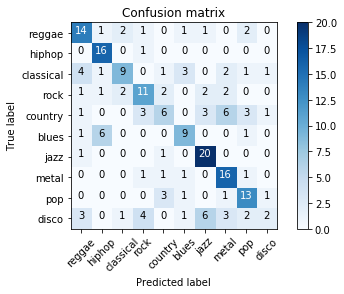

In [65]:
%%time
# Train
lr_classifier = LogisticRegression(penalty='l2')
lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results('LR', y_test, pred_probs)

# Save
with open('pred_probas/lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Random Forest

Test Set Accuracy =  0.62
Test Set F-score =  0.60
ROC AUC = 0.927
Confusion matrix, without normalization
[[15  0  3  0  0  1  2  0  0  1]
 [ 0 16  0  0  0  0  0  0  1  0]
 [ 1  1 14  0  0  1  0  1  2  2]
 [ 0  1  1 11  3  0  1  2  0  2]
 [ 0  0  0  2 12  0  3  3  2  1]
 [ 0  6  0  1  0 10  0  0  0  0]
 [ 1  0  0  0  0  0 21  0  0  0]
 [ 0  1  1  1  1  1  0 15  0  0]
 [ 0  0  1  2  2  1  1  0 12  0]
 [ 2  0  2  7  0  4  3  1  2  1]]
CPU times: user 3.06 s, sys: 664 ms, total: 3.72 s
Wall time: 3.03 s


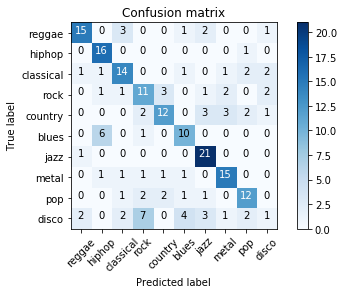

In [66]:
%%time
# Train
rf_classifier = RandomForestClassifier(n_estimators=500, min_samples_split=5)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results('RF', y_test, pred_probs)

# Save
with open('pred_probas/rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Support Vector Machines

Test Set Accuracy =  0.65
Test Set F-score =  0.65
ROC AUC = 0.925
Confusion matrix, without normalization
[[14  0  1  0  0  2  2  0  2  1]
 [ 0 16  0  1  0  0  0  0  0  0]
 [ 1  0 12  0  1  4  0  1  0  3]
 [ 0  1  1 13  2  0  1  2  0  1]
 [ 0  0  0  1 14  0  1  1  3  3]
 [ 0  3  0  2  0 12  0  0  0  0]
 [ 1  0  0  1  1  0 18  0  0  1]
 [ 0  0  0  1  2  1  0 14  1  1]
 [ 0  0  1  2  2  0  0  2 12  0]
 [ 1  0  1  4  0  1  4  1  2  8]]
CPU times: user 984 ms, sys: 640 ms, total: 1.62 s
Wall time: 935 ms


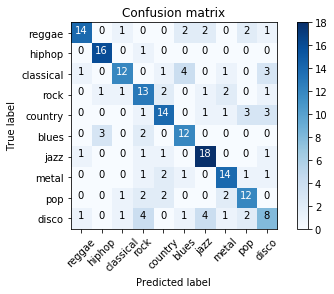

In [67]:
%%time
# Train
svm_classifier = SVC(C=10000.0, probability = True, kernel='rbf')
svm_classifier.fit(x_train, y_train)

# Predict
pred_probs = svm_classifier.predict_proba(x_test)

# Results
display_results('SVM', y_test, pred_probs)

# Save
with open('pred_probas/svm_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Gradient Boosting

Test Set Accuracy =  0.63
Test Set F-score =  0.62
ROC AUC = 0.925
Confusion matrix, without normalization
[[14  1  2  0  0  1  3  0  1  0]
 [ 0 16  0  0  0  0  0  0  1  0]
 [ 2  1 14  0  0  0  0  1  3  1]
 [ 0  1  1 12  3  0  1  2  0  1]
 [ 0  0  1  3 10  0  5  1  3  0]
 [ 0  5  0  2  0 10  0  0  0  0]
 [ 2  0  0  0  1  0 19  0  0  0]
 [ 0  0  0  0  2  0  0 17  1  0]
 [ 0  0  1  1  3  0  0  0 12  2]
 [ 2  0  2  6  1  1  1  2  2  5]]
CPU times: user 10 s, sys: 664 ms, total: 10.7 s
Wall time: 9.98 s


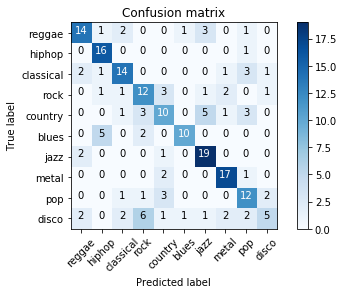

In [68]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results('xgb', y_test, pred_probs)

# Save
with open('pred_probas/xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Most Important Feature

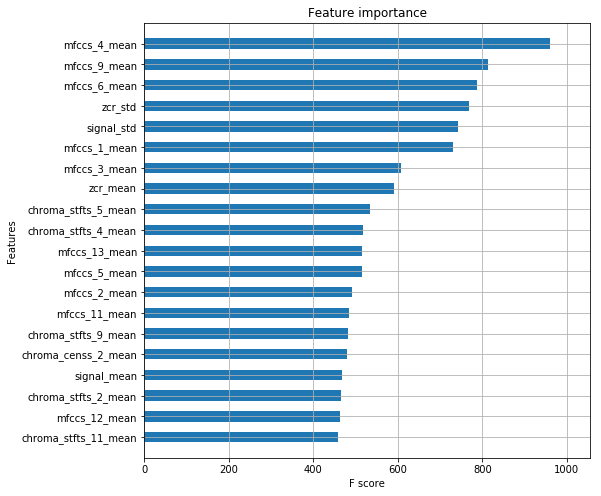

In [69]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=20, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)
plt.savefig('plots/important_features.jpg', bbox_inches='tight')

In [70]:
contribution_scores = xgb_classifier.feature_importances_

In [71]:
top_n = [10, 20, 30]
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_test = selection.transform(x_test)
    
    # Train
    select_svm_classifier = SVC(C=10000.0, probability = True, kernel='rbf')
    select_svm_classifier.fit(select_x_train, y_train)

    # Predict
    pred_probs = select_svm_classifier.predict_proba(select_x_test)

    # Results
    display_results('SVM_with_'+str(n)+"_features", y_test, pred_probs, cm = False)     
    print()

Stats for top 10 features:
Test Set Accuracy =  0.63
Test Set F-score =  0.64
ROC AUC = 0.915
()
Stats for top 20 features:
Test Set Accuracy =  0.68
Test Set F-score =  0.68
ROC AUC = 0.935
()
Stats for top 30 features:
Test Set Accuracy =  0.66
Test Set F-score =  0.66
ROC AUC = 0.929
()
